In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import pandas as pd

In [30]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_, or_

In [32]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [33]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [34]:
# We can view all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [35]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

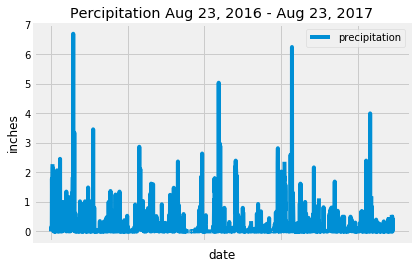

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date = list(np.ravel(last_date))[0]
#last_date = dt.datetime.strptime(last_date['date'], "%Y-%m-%d")
last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")

last_date_year = int(dt.datetime.strftime(last_date, "%Y"))
last_date_month = int(dt.datetime.strftime(last_date, "%m"))
last_date_day = int(dt.datetime.strftime(last_date, "%d"))

year_ago = dt.date(last_date_year-1 , last_date_month, last_date_day)
#year_ago = dt.date(last_date_year , last_date_month, last_date_day) - dt.timedelta(days=365)

result = session.query(measurement.date, measurement.prcp).filter(measurement.date>=year_ago).\
order_by(measurement.date).all()

query_result = pd.DataFrame(result)
query_result = query_result.rename(columns = {'prcp' : 'precipitation'})
query_result.set_index('date', inplace=True)
query_result = query_result.sort_index(ascending=True)
query_result.head()

query_result.plot(title="Percipitation Aug 23, 2016 - Aug 23, 2017")
plt.ylabel("inches")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_result.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(station.station)).all()

print(f"Numner of stations in dataset = {station_count[0][0]}")

Numner of stations in dataset = 9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_list = session.query(measurement.station, func.count(measurement.id)).group_by(measurement.station).\
order_by(func.count(measurement.id).desc()).all()

station_list = pd.DataFrame(station_list, columns = ['Stations', 'Frequency'])
print(station_list)

most_active = session.query(station.name, station.station).filter(station.station == 'USC00519281').all()
print(f"Most active station id: {most_active[0][1]} , name: {most_active[0][0]}")

      Stations  Frequency
0  USC00519281       2772
1  USC00519397       2724
2  USC00513117       2709
3  USC00519523       2669
4  USC00516128       2612
5  USC00514830       2202
6  USC00511918       1979
7  USC00517948       1372
8  USC00518838        511
Most active station id: USC00519281 , name: WAIHEE 837.5, HI US


In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_temp = session.query(measurement.station, func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
max_temp = session.query(measurement.station, func.max(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
avg_temp = session.query(measurement.station, func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()

print(f"Minimum Temp recorded in station: {min_temp[0][0]} is {min_temp[0][1]}")
print(f"Maximum Temp recorded in station: {min_temp[0][0]} is {max_temp[0][1]}")
print(f"Average Temp recorded in station: {min_temp[0][0]} is {round(avg_temp[0][1],2)}")

Minimum Temp recorded in station: USC00519281 is 54.0
Maximum Temp recorded in station: USC00519281 is 85.0
Average Temp recorded in station: USC00519281 is 71.66


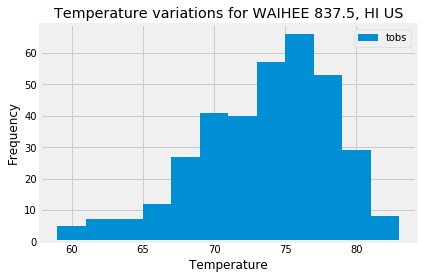

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#print(session.query(measurement.station, func.count(measurement.tobs)).group_by(measurement.station).\
#filter(measurement.date>=year_ago).order_by(func.count(measurement.tobs).desc()).all())

highest_tobs = session.query(measurement.station, measurement.tobs).\
filter(and_(measurement.date>=year_ago, measurement.station == 'USC00519281')).all()

df_highest_tobs = pd.DataFrame(highest_tobs, columns = ['Station', 'tobs'])

df_highest_tobs.hist(bins=12, label = 'tobs')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature variations for WAIHEE 837.5, HI US")
plt.legend(loc='upper right')
plt.show()

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
